# W kernels

In [15]:
from __future__ import print_function
import sys
import os

import numpy
import scipy

sys.path.append(os.path.join('..','..'))
from crocodile.clean import *
from crocodile.synthesis import *
from crocodile.simulate import *
from util.visualize import *

from ipywidgets import interact, interact_manual, fixed, ToggleButtons, Select, SelectMultiple
from matplotlib import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = 16, 12

Parameters, with reasonable choice of `ff_size`, which is `NpixFF` in `wslicimg`:

In [16]:
theta_fov = 0.02  # Size of the field of view in radians
lam_fov   = 10000 # Size of the uv-grid in wavelengths
w         = 10000  # w-value to generate the GCF for
oversampling = 5

Determine required dimensions. As explained in [SKA-TEL-SDP-IMG-Wkernels], we can calculate the appropriate $w$-kernel support using the formula:

$$\left|u\right| < \sqrt{ \left( \frac{w \Theta}2\right)^2 + \frac{\left(\sqrt{w}\right)^3 \Theta}{2 \pi \eta}}$$

In [22]:
eta = 0.001
gcf_supp = theta_fov * numpy.sqrt((w * theta_fov / 2.) ** 2 + (w**1.5 * theta_fov / 2 / numpy.pi / eta))
gcf_supp = int(numpy.ceil(gcf_supp))//2*2+1
print("convolution function support: %d" % gcf_supp)

convolution function support: 37


As we now know the convolution function's radius, we can proceed to calculating the size we need to generate the far-field pattern for: Larger than twice the support.

Additionally, the field pixel size must be odd exactly if the oversampling rate is odd. This is more of a technical restriction - FFT forces the zero frequency to lie on a pixel, which might cause padding to move the image centre by half a pixel.

In [23]:
ff_size = gcf_supp*2+1
if oversampling % 2 != ff_size % 2:
    ff_size += 1
theta = 1.0 * ff_size / lam_fov
print("far field size: %d, far field theta: %g" % (ff_size, theta))

far field size: 75, far field theta: 0.0075


Now we can proceed to calculating the actual $w$-kernel. We start in the image plane, where the $w$-effect in the far field is given by:

$$G(l,m,w) = {\rm e}^{-2\pi i  \left[w( \sqrt{1-l^2-m^2} - 1 )\right] } $$

(Eq. 11; Cornwell+ 2008 http://arxiv.org/pdf/0807.4161v1.pdf )

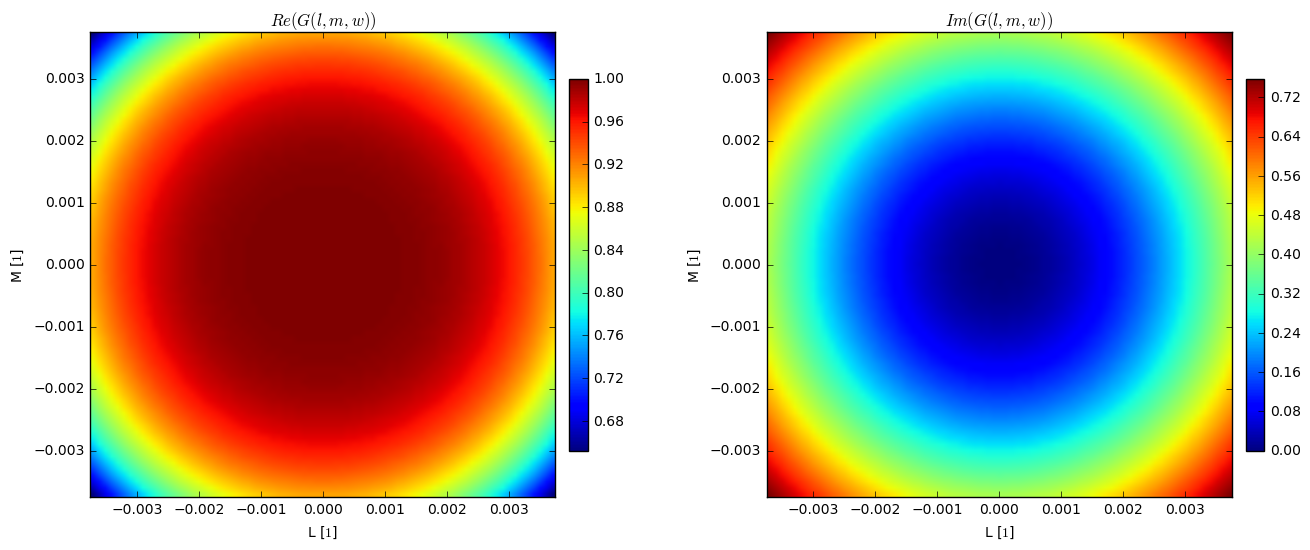

In [24]:
ff = w_kernel_function(ff_size, theta, w)
if ff_size % 2 == 0 and False:
    ff[0,:] = numpy.zeros(ff_size)
    ff[:,0] = numpy.zeros(ff_size)
show_image(ff, "G", theta, extra_dep="w")

To oversample, we want to increase the (pixel) size of the far-field by the oversampling factor. This corresponds to increasing the resolution after FFT. However, we do not actually want to increase the size of the pattern, so we simply pad the pattern. This means we actually calculate $G$ multiplied by the box function:

$$G^{pad}(l,m,w) = G(l,m,w)\ \Pi\left(\frac {2l}{l_{size}}\right) \Pi\left(\frac {2m}{m_{size}}\right) $$

This is the same thing as convolving the fourier transform with a $\text{sinc}$ function pattern:

$$\tilde G^{pad}(u,v,w) = \tilde G(u,v,w) * \frac{l_{size}m_{size}}{8\pi^2}
  \text{sinc}\left(\frac{l_{size}u}{4}\right)
  \text{sinc}\left(\frac{m_{size}v}{4}\right)$$

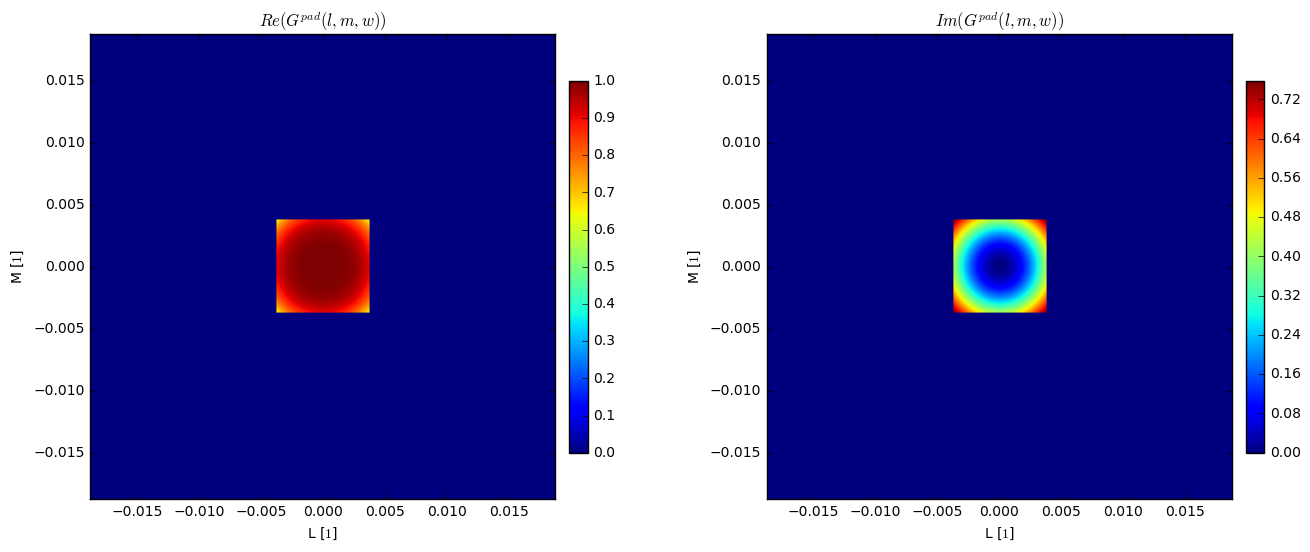

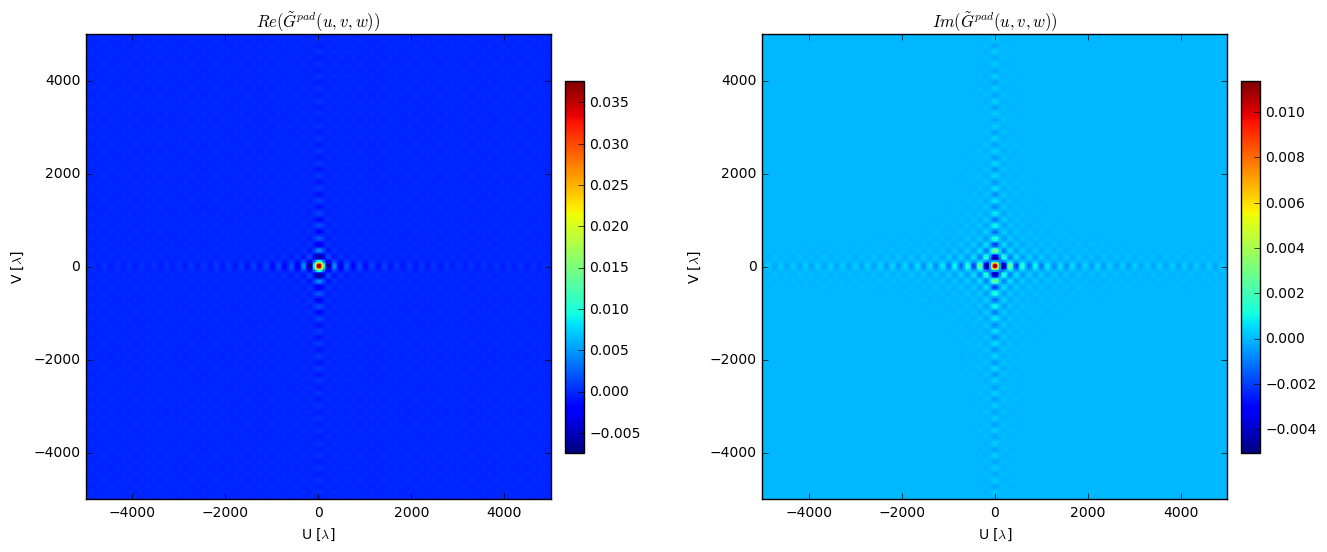

In [25]:
padff = pad_mid(ff, ff_size * oversampling)
show_image(padff, "G^{pad}", theta * oversampling, extra_dep="w")
af0 = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.ifftshift(padff)))
show_grid(af0, r"\tilde G^{pad}", ff_size / theta)

Now we can finally extract the $w$-kernel in the aperture field, i.e., the convolution kernel. This kernel is expected to fulfill some basic consistency conditions - it should have a sum of around 1 and closely reproduce the original image if we re-add it into the original grid at an offset.

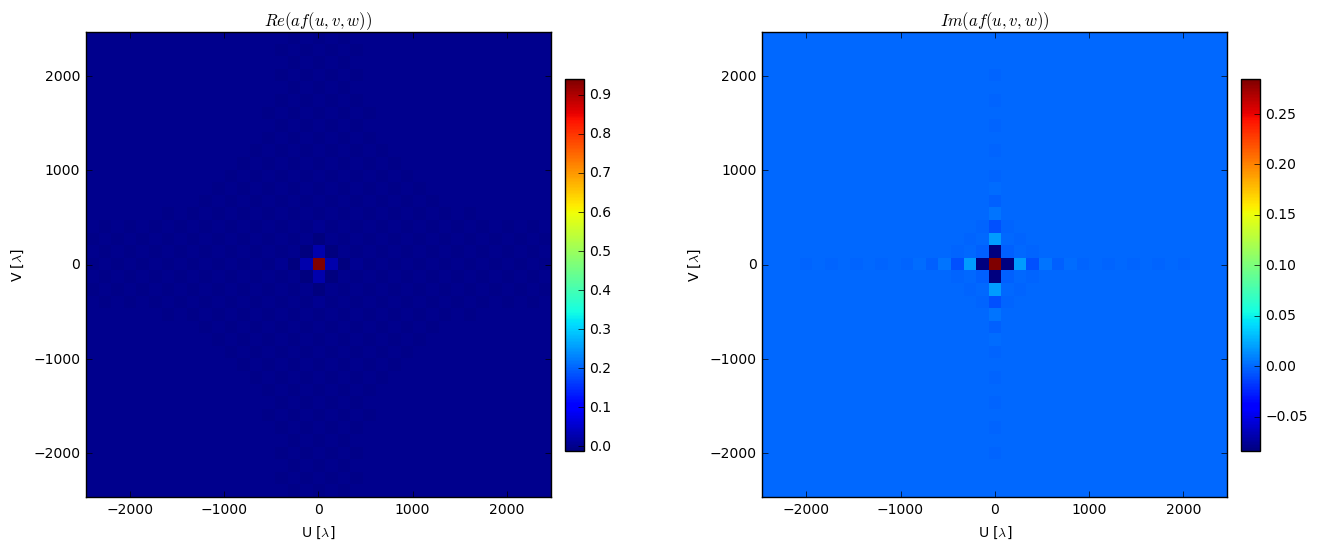

Sum: (0.999804717285+0.000413720172959j), 0.0457493% off


/home/peter/cam/crocodile/build/local/lib/python3.4/site-packages/ipykernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


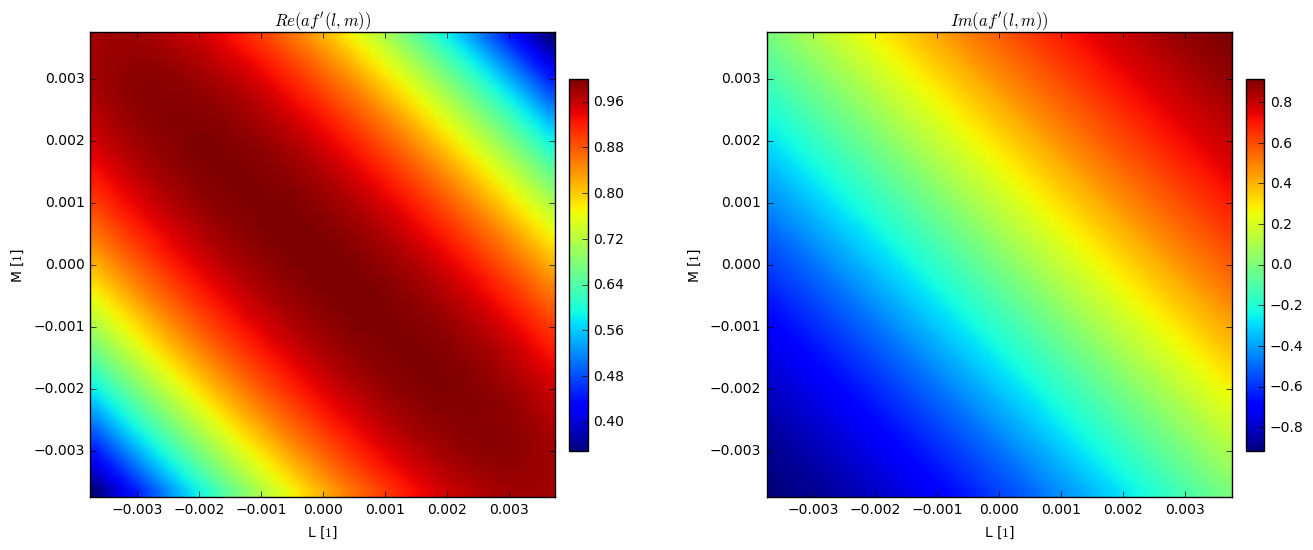

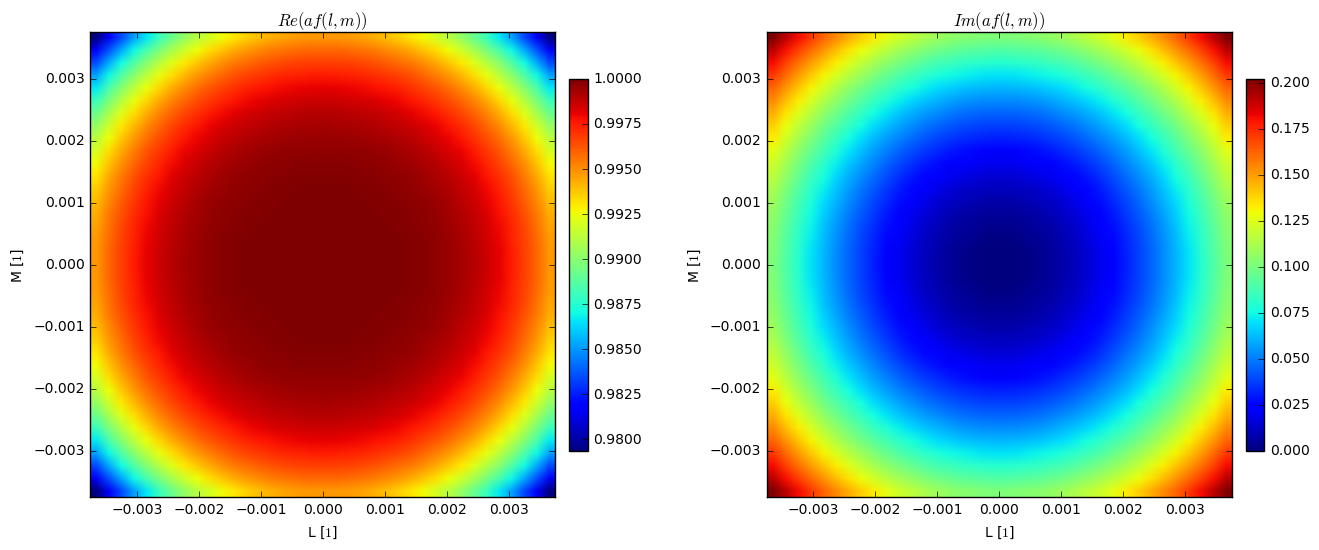

In [26]:
af=kernel_oversample(padff, ff_size, oversampling, gcf_supp)
def show_kernel(uo,vo):
    show_grid(af[vo,uo], "af", af[uo,vo].shape[0]/theta);
    # Check normalisation - the image sum should be almost exactly 1.
    s = numpy.sum(af[vo,uo])
    print("Sum: %s, %g%% off" % (str(s), 100*abs(s-1)))
    # Check that the oversampled kernel can reproduce the original far-field
    # image. We do this by adding it into a grid with appropriate offsets...
    afp = numpy.zeros((ff_size*oversampling,ff_size*oversampling))
    afp[vo::oversampling, uo::oversampling] = pad_mid(af[vo, uo], ff_size)
    ffp = numpy.fft.fftshift(numpy.fft.fft2(numpy.fft.ifftshift(afp)))
    show_image(extract_mid(ffp,gcf_supp), "af'", theta)
    show_image(extract_mid(padff, gcf_supp), "af", theta)
interact(show_kernel, uo=(0,oversampling-1,1), vo=(0,oversampling-1,1));